# Creating a basic neural network with Tensorflow v1.15

This notebook is inspired by some code available in the [Coursera Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning#courses) and has the goal to reproduce the same logic as [Tensorflow playground](https://playground.tensorflow.org/) but in Python.

So in summary you'll be able to choose the following hyperparameters :
- number of hidden layers
- number of units in each layers
- loss function
- activation per layer
- optimizer to use
- learning rate
- batch size

## Data used

This notebook's goal is to create a few neural networks with `tensorflow 1.15` and try to submit the result into Kaggle.

[Competition link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/).

## Import packages

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Check GPU is working

In [2]:
with tf.Session() as sess:
    devices = sess.list_devices()
sess.close()

devices

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 10038302858391953019),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9300626239435706983),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 2898054394965409782),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1267990528, 17442708505485129454)]

In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

## Load data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Prepare data

In [5]:
train.shape

(1460, 81)

In [67]:
target = 'SalePrice'
# cols_to_keep = ['LotArea', 'TotalBsmtSF'] + [target]

Select variable correlated with target `SalePrice` (threshold > 0.1)

In [ ]:
# Define function to get weighted correlation 
# for categoricals variable

def corr_num_cat_var(df, num_var, cat_var):
    """Compute weighted correlation for a 
    categorical variable.
    
    """
    dummies = pd.get_dummies(df[cat_var])
    sum_df = dummies.sum()
    
    dummies[num_var] = df[num_var]
    corr = dummies.corr()
    corr = corr[num_var].iloc[:-1]
    
    weighted_corr = np.sum(corr*sum_df) / len(df)
    
    return weighted_corr

def get_correlatd_cat_feats(df, target, threshold):
    """Returns feature names that
    are correlated to the target
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to work on
    target: str
        target name
    threshold: float
        correlation threshold to keep feature
        
    Returns
    -------
    list:
        list of categorical features to keep
    """
    cat_vars = train.select_dtypes('object').columns
    corr_df = pd.Series()

    for cat_var in cat_vars:
        corr = corr_num_cat_var(train, target, cat_var)
        corr_df.loc[cat_var] = corr

    cat_feats = corr_df[corr_df.abs() > threshold].index.tolist()
    return cat_feats

In [ ]:
corr = train.corr()[target]

threshold = 0.1
num_feats = corr[corr.abs() > threshold].index.tolist()
cat_feats = get_correlatd_cat_feats(train, target, threshold)

cols_to_keep = num_feat + cat_feat

In [ ]:
df_na = train[cols_to_keep].isna().sum()
df_na[df_na > 0]

#### Create preparation pipeline

In [ ]:
from sklearn.preprocessing import Normalizer

def prepare_data(df, cols_to_keep, target, 
                 dummies_cols=None, transformer=None):
    """
    """
    df = df[cols_to_keep]
    num_feats = df.select_dtypes('number').columns.tolist()
    cat_feats = df.select_dtypes('object').columns.tolist()
    
    if target in num_feats:
        num_feats = [f for f in num_feats if f != target]
    
    # Missing values
    df[num_feats] = df[num_feats].fillna(0)
    df[cat_feats] = df[cat_feats].fillna('Missing value')
    
    dummies_exists = dummies_cols is not None
    if not dummies_exists:
        dummies_cols = list()
    else:
        for c in dummies_cols:
            df[c] = 0
    
    for feature in cat_feats:
        dummies = pd.get_dummies(df[feature], prefix=feature)
        if not dummies_exists:
            df[dummies.columns] = dummies
            dummies_cols += dummies.columns.tolist()
        else:
            for c in dummies.columns:
                if c in dummies_cols:
                    df[c] = dummies[c]
                    
        df = df.drop(columns=feature)
    
    if transformer is None:
        transformer = Normalizer().fit(df[num_feats])

    df[num_feats] = transformer.transform(df[num_feats])
    
    return df, transformer, dummies_cols

In [ ]:
train_df, transformer, dummies_cols = prepare_data(train, cols_to_keep, target)

## split train test

In [69]:
def get_train_test(df):
    X, y = df.drop(columns=target), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [70]:
X_train, X_test, y_train, y_test = get_train_test(train_df)

## Create NN

### Initialize Weight and bias

In [10]:
def initialize_parameters(n_units, n_features, n_units_output=1):    
    """Initialize parameters Weight and bias and stored them
    in a dictionnary following this format : {'Wl': tf.Variable, 'bl': tf.Variable, ...}.
    
    Where `l` is the layer number. 
    
    The dictionnary also store number of layers L (output layer include)
    
    Parameters
    ----------
    n_units: list
        list of number of units per layer
    n_features: int
        number of features at input layer
    n_units_output: int (default 1)
        number of units at output layer
        
    Returns
    -------
    dict:
        Dictionnary of parameters    
    """
    tf.set_random_seed(1) 
    parameters = {}

    n_units += [n_units_output]    
    n_layers = len(n_units)
    
    parameters['L'] = n_layers
    
    for l in range(0,n_layers):
        num_units = n_units[l]   
        W = f'W{l}'
        b = f'b{l}'

        prev_n_units = n_features if l == 0 else n_units[l-1]

        # Using Xavier initializer for Weight 
        # Todo custom
        parameters[W] = tf.get_variable(name=W, shape=[prev_n_units, num_units], 
                                        initializer = tf.contrib.layers.xavier_initializer())
        # Using zeros initializer for bias
        parameters[b] = tf.get_variable(name=b, shape=[1,num_units], 
                                        initializer = tf.zeros_initializer())

    return parameters

In [11]:
# Test for a NN with 2 hidden layers, 20 features and 2 output units
tf.reset_default_graph()   

initialize_parameters(n_units=[10,5], n_features=20, n_units_output=2)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



{'L': 3,
 'W0': <tf.Variable 'W0:0' shape=(20, 10) dtype=float32_ref>,
 'b0': <tf.Variable 'b0:0' shape=(1, 10) dtype=float32_ref>,
 'W1': <tf.Variable 'W1:0' shape=(10, 5) dtype=float32_ref>,
 'b1': <tf.Variable 'b1:0' shape=(1, 5) dtype=float32_ref>,
 'W2': <tf.Variable 'W2:0' shape=(5, 2) dtype=float32_ref>,
 'b2': <tf.Variable 'b2:0' shape=(1, 2) dtype=float32_ref>}

### Compute forward propagation

In [12]:
def compute_layer(A, parameters, layer, activation='relu'):
    """Compute calculus for a given layer
    
    Follow this formula : Z_l = A_{l-1} * W_l + b_l
    
    if activation is set then this function returns : 
    A_l = activation_function(Z_l) 
    
    Where :
    - A is (1, nb units prev layer)
    - W is (nb units prev layer, nb units current layer)
    - b is (1, nb units current layer)
    
    Parameters
    ----------
    A: tf.Variable
        output of the previous layer
    parameters: dict
        Dictionnary of parameters  
    layer: int
        number of the current layer
    activation: str (default relu)
        activation function, if None then just 
        compute the linear calculus
        
    Returns
    -------
    tf.Variable
        Output of the layer calculus
    """
    W = parameters['W'+str(layer)]
    b = parameters['b'+str(layer)]
    
    Z = tf.add(tf.matmul(A,W), b, name=f'Z{layer}')
    
    if activation is not None:
        return tf.nn.relu(Z, name=f'A{layer}') 
    
    return Z

def forward_propagation(X, parameters, activation='relu'):
    """Compute forward propagation given input X and
    initialized parameters.
    
    You can custom activation functionfor the hidden layers
    
    Parameters
    ----------
    X: tf.Variable
        input data shape (n_rows, n_features) 
    parameters: dict
        Dictionnary of parameters  
    activation: str (default relu)
        activation function for hidden layers
        
    Returns
    -------
    tf.Variable
        Prediction output shape (n_rows, n_units_output)
    """
    A = X
    if 'L' not in parameters:
        n_layers = int(len(parameters) / 2)
    else:
        n_layers = parameters['L']
    
    for l in range(0, n_layers):
        act_l = activation if l != n_layers-1 else None
        
        A = compute_layer(A, parameters, layer=l, activation=act_l)
    
    return A

In [13]:
# Test for a NN with 2 hidden layers, 20 features and 2 output units
tf.reset_default_graph()   

parameters = initialize_parameters(n_units=[10,5], n_features=20, n_units_output=2)

X = tf.placeholder(tf.float32, shape=(None, 20), name='X')

forward_propagation(X, parameters, activation='relu')

<tf.Tensor 'Z2:0' shape=(?, 2) dtype=float32>

### Compute cost

Handle the following cost function :

-----

- `MSE`: Mean square Error (or Quadratic Loss or L2 Loss)

$MSE = \frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.square(Y_pred - Y_real))
```

-----
- `RMSE`: Root Mean square Error 

$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}}$

```python
def loss(Y_pred, Y_real):
    return tf.sqrt(tf.reduce_mean(tf.square(Y_pred - Y_real)))
```
-----
- `RMSE log`: Root Mean square Error (log values)

$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(\log{(y_i)} - \log{(\hat{y_i})})^2}}$

```python
def loss(Y_pred, Y_real):
    return tf.sqrt(tf.reduce_mean(tf.abs(tf.log(Y_pred) - tf.log(Y_real))))
```

-----
- `MAE`: Mean Absolute Error (or L1 Loss)

$MAE = \frac{1}{n} \sum_{i=1}^{n}{|y_i - \hat{y_i}|}$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.abs(Y_pred - Y_real))
```

-----
- `Entropy`: Cross Entropy Loss (or Negative Log Likelihood)

$\text{Cross Entropy Loss} = - (y_i\log{\hat{y_i}} + (1-y_i)\log{1-\hat{y_i}})$

```python
def loss(Y_pred, Y_real):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels, logits))

```

In [14]:
def compute_loss(Y_pred, Y_real, loss='RMSE'):
    """Compute loss given a loss function
    
    Loss available : 
    - MSE
    - RMSE
    - RMSE log
    - MAE
    - Entropy
    
    Parameters
    ----------
    Y_pred: tf.Variable
        Predictions from the model
    Y_real: tf.Variable
        Real output
    loss: str (default RMSE)
        loss function to compute
        
    Returns
    -------
    tf.Variable:
        Loss of the model
    """
    if loss == 'MSE':
        return tf.reduce_mean(tf.square(Y_pred - Y_real), name='loss')
    
    elif loss == 'RMSE':
        return tf.sqrt(tf.reduce_mean(tf.square(Y_pred - Y_real)), name='loss')
    
    elif loss == 'RMSE log':
        return tf.sqrt(tf.reduce_mean(tf.square(tf.log(Y_pred) - tf.log(Y_real)), name='loss'))
        
    elif loss == 'MAE':
        return tf.reduce_mean(tf.abs(Y_pred - Y_real), name='loss')
    
    elif loss == 'Entropy':
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(Y_real, Y_pred), name='loss')
    
    return None


In [15]:
# Test
tf.reset_default_graph()   

parameters = initialize_parameters(n_units=[10], n_features=5)

X = tf.placeholder(tf.float32, shape=(None, 5), name='X')
Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')

Y_pred = forward_propagation(X, parameters, activation='relu')

In [16]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='MSE')

<tf.Tensor 'loss:0' shape=() dtype=float32>

In [17]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='RMSE')

<tf.Tensor 'loss_1:0' shape=() dtype=float32>

In [18]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='RMSE log')

<tf.Tensor 'Sqrt:0' shape=() dtype=float32>

In [19]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='MAE')

<tf.Tensor 'loss_3:0' shape=() dtype=float32>

In [20]:
compute_loss(Y_pred=Y_pred, Y_real=Y, loss='Entropy')

<tf.Tensor 'loss_4:0' shape=() dtype=float32>

### Optimizer selection

This the list of possible optimizer to train the neural network :

- GradientDescent: [`tf.train.GradientDescentOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/GradientDescentOptimizer)
- Momentum: [`tf.train.MomentumOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/MomentumOptimizer)
- Adagrad: [`tf.train.AdagradOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdagradOptimizer)
- Adadelta: [`tf.train.AdadeltaOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdadeltaOptimizer)
- RMSProp: [`tf.train.RMSPropOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/RMSPropOptimizer)
- Adam: [`tf.train.AdamOptimizer`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdamOptimizer)

In [21]:
def select_optimizer(optimizer='GradientDescent'):
    """Select the optimizer
    
    Available optimizers:
    - GradientDescent
    - Momentum
    - Adagrad
    - Adadelta
    - RMSProp
    - Adam
    
    Parameters
    ----------
    optimizer: str (default GradientDescent)
        optimizer to select
        
    Returns
    -------
    tf.train.Optimizer
        Optimizer object
    """
    if optimizer == 'GradientDescent':
        return tf.train.GradientDescentOptimizer
    elif optimizer == 'Momentum':
        return tf.train.MomentumOptimizer
    elif optimizer == 'Adagrad':
        return tf.train.AdagradOptimizer
    elif optimizer == 'Adadelta':
        return tf.train.AdadeltaOptimizer
    elif optimizer == 'RMSProp':
        return tf.train.RMSPropOptimizer
    elif optimizer == 'Adam':
        return tf.train.AdamOptimizer
    
    raise ValueError('Optimizer choosen not available please select a valid one')
    
    return None

In [22]:
select_optimizer(optimizer='Adam')

tensorflow.python.training.adam.AdamOptimizer

### Tensorboard function

In [23]:
def create_tensorboard(sess, L, grads_and_vars, loss, name='dashboard'):
    """
    """
    if not os.path.exists('summaries'):
        os.mkdir('summaries')
    if not os.path.exists(os.path.join('summaries',name)):
        os.mkdir(os.path.join('summaries',name))

    summ_writer = tf.summary.FileWriter(os.path.join('summaries',name), sess.graph)    
    
    # tf_loss_summary :     you feed in a value by means of a placeholder, 
    #                       whenever you need to publish this to the board
    
    with tf.name_scope('performance'):
        tf_loss_ph = tf.placeholder(tf.float32,shape=None,name='loss_summary')
        tf_loss_summary = tf.summary.scalar('loss', tf_loss_ph)

        
    # tf_gradnorm_summary : this calculates the l2 norm of the gradients 
    #                       of the last layer of your neural network. 
    #                       Gradient norm is a good indicator of whether the weights 
    #                       of the neural network are being properly updated. 
    #                       A too small gradient norm can indicate vanishing gradient 
    #                       or a too large gradient can imply exploding gradient phenomenon.
    
    for g, v in grads_and_vars:
        if f'W{L-1}' in v.name:
            with tf.name_scope('gradients'):
                tf_last_grad_norm = tf.sqrt(tf.reduce_mean(g**2))
                tf_gradnorm_summary = tf.summary.scalar('grad_norm', tf_last_grad_norm)
                break
                
    performance_summaries = tf.summary.merge([tf_loss_summary])    
    
    return {
        'writer': summ_writer, 
        'loss': tf_loss_ph, 
        'gradnorm': tf_gradnorm_summary,
        'perf': performance_summaries
    }

### Generate NN with optimizer for back propagation

In [138]:
def plot_cost(train_costs, test_costs=None):
    """Plot the cost
    """
    plt.plot(np.squeeze(train_costs), label='train')
    if test_costs is not None:
        plt.plot(np.squeeze(test_costs), label='test')
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend(loc="upper right")
    plt.show()
    

def fit(feed_dict_train, parameters, optimizer, loss, learning_rate, num_epochs,
        epsilon, early_stopping, feed_dict_test, batch_size=None):
    """
    """
    # TODO : implement batch size
    
    init = tf.global_variables_initializer()
    train_costs = list()
    test_costs = list()
    num_epochs = 100000000 if num_epochs is None else num_epochs
    L = parameters['L']
    old_param = list()
    
    with tf.Session() as sess:
        sess.run(init)
        
        # board = create_tensorboard(sess, L, grads_and_vars, loss, name='dashboard')
        # summ_writer = board['writer']
        # tf_loss_ph = board['loss']
        # tf_gradnorm_summary = board['gradnorm']
        # performance_summaries = board['perf']
        
        for epoch in range(num_epochs):
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            # epoch_l_train, gn_summ = sess.run([loss, tf_gradnorm_summary], feed_dict=feed_dict_train)
            epoch_l_train = sess.run(loss, feed_dict=feed_dict_train)
            epoch_l_test = sess.run(loss, feed_dict=feed_dict_test)
            
            # summ = sess.run(performance_summaries, feed_dict={tf_loss_ph: epoch_l_train})
            
            # summ_writer.add_summary(gn_summ, epoch)
            # summ_writer.add_summary(summ, epoch)

            if epoch % display_freq == 0:
                lr = sess.run(learning_rate)
                print ("At epoch %i, learning rate is %.8f train cost is: %f and test cost is: %f" % (
                    epoch, lr, epoch_l_train, epoch_l_test))
            
            if str(epoch_l_train) == 'nan':
                print("Cost is nan.")
                break
            
            train_costs.append(epoch_l_train)
            test_costs.append(epoch_l_test)
                
            # Early stopping slow decrease
            if len(train_costs) > 2:
                if train_costs[-2] - train_costs[-1] < epsilon:
                    print('Stop at epoch %i. because cost decrease is less than epsilon.'% (epoch))
                    break
                        
            old_param.append(parameters)
            
            # early stopping increase
            if epoch > early_stopping+1:
                if train_costs[epoch] > train_costs[-early_stopping]:
                    print('Stop at epoch %i. because training cost has increase in the last %i epochs.'% (
                        epoch, early_stopping))
                    
                    parameters = old_param[-early_stopping]
                    break
                    
                if test_costs[epoch] > test_costs[-early_stopping]:
                    print('Stop at epoch %i. because validation cost has increase in the last %i epochs.'% (
                        epoch, early_stopping))
                    
                    parameters = old_param[-early_stopping]
                    break
                    
                
        # Plot the cost
        plot_cost(train_costs, test_costs)
                
        # lets save the parameters in a variable
        del parameters['L'], old_param
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
    
    sess.close()
    return parameters

def neural_network(X_train, Y_train, X_test=None, Y_test=None,
                   learning_rate=0.01, decay_step=1000, base_rate=0.95,
                   num_epochs=None, epsilon=0.0001, early_stopping=10,
                   n_units=[1], activation='relu', loss_fn='RMSE', 
                   optimizer_name='Adam', display_freq=100):
    """
    
    Parameters
    ----------
    X_train: 2 dimensions array like 
        array shape (n_rows, n_features)
    Y_train: array like
        array shape (n_rows, 1)
    X_test: 2 dimensions array like (optional)
        array shape (n_rows, n_features)
    Y_test: array like (optional)
        array shape (n_rows, 1)
    learning_rate: float
        Learning rate for the model
    num_epochs: int (optional)
        number of epoch to train
        If None then it stop if the cost difference
        is less than epsilon
    epsilon: float (default 0.0001)
        threshold to stop learning
    early_stopping: int (default 10)
        Number of epochs to use early stopping if training
        cost increase
    n_units: list (default [1])
        list of units per layer
    activation: str (default 'relu')
        activation function for hidden layers
    loss_fn: str (default RMSE)
        loss function to compute
    optimizer_name: str (default Adam)
        optimizer to use
    display_freq: int (default 100)
        display frequency to follow the model learning
    
    Returns
    -------
    dict:
        Dictionnary of the trained parameters
    """
    
    if type(X_train) == pd.DataFrame:
        X_train = X_train.values
        Y_train = Y_train.values.reshape(-1,1)
        
    if X_test is not None:
        if type(X_test) == pd.DataFrame:
            X_test = X_test.values
            Y_test = Y_test.values.reshape(-1,1)
    
    # Reset graph
    tf.reset_default_graph()
    # Set seed
    tf.set_random_seed(42)
    
    _, n_features = X_train.shape
    
    # Initialize placeholder    
    X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
    Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
    
    # Initialize parameters
    parameters = initialize_parameters(n_units, n_features, n_units_output=1)
    
    # Create forward propagation graphs
    Y_pred = forward_propagation(X, parameters, activation)
    
    # Create loss computation graph
    loss = compute_loss(Y_pred, Y, loss=loss_fn)
    
#     decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)  
    
    global_step = tf.Variable(0, trainable=False, name='learning_rate')
    learning_rate = tf.train.exponential_decay(learning_rate,
            global_step, decay_step, base_rate, staircase=True)

    
    # Create Optimizer 
    optimizer_obj = select_optimizer(optimizer_name)(learning_rate)
    # grads_and_vars = optimizer_obj.compute_gradients(loss)    
    optimizer = optimizer_obj.minimize(loss, global_step=global_step)
    
    feed_dict_train = {X: X_train, Y: Y_train}
    feed_dict_test = {X: X_test, Y: Y_test} if X_test is not None else None
    
    parameters = fit(feed_dict_train, parameters, optimizer, loss, learning_rate,
                     num_epochs, epsilon, early_stopping, feed_dict_test)
    
    return parameters
    

### Test the training

At epoch 0, learning rate is 0.01000000 train cost is: 11.426588 and test cost is: 11.382075
At epoch 100, learning rate is 0.01000000 train cost is: 5.093220 and test cost is: 5.062395
At epoch 200, learning rate is 0.01000000 train cost is: 3.759574 and test cost is: 3.730151
At epoch 300, learning rate is 0.01000000 train cost is: 2.948740 and test cost is: 2.920679
At epoch 400, learning rate is 0.01000000 train cost is: 2.361535 and test cost is: 2.335022
At epoch 500, learning rate is 0.01000000 train cost is: 1.900781 and test cost is: 1.876168
At epoch 600, learning rate is 0.01000000 train cost is: 1.523095 and test cost is: 1.500944
At epoch 700, learning rate is 0.01000000 train cost is: 1.206378 and test cost is: 1.187585
At epoch 800, learning rate is 0.01000000 train cost is: 0.939653 and test cost is: 0.925654
At epoch 900, learning rate is 0.01000000 train cost is: 0.719832 and test cost is: 0.712876


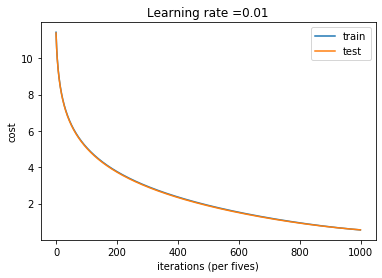

Parameters have been trained!


In [140]:
# Choose hyper parameters
learning_rate = 0.01
decay_step = 1000 
base_rate = 0.9
num_epochs = 1000 
epsilon = 0.000000001
early_stopping = 10
n_units = [20,10]
activation = 'relu' 
loss_fn = 'RMSE log'
optimizer = 'Adam'
# batch_size to implement

# Helper parameters
display_freq = 100

parameters = neural_network(X_train, y_train, X_test, y_test,
                            learning_rate, decay_step, base_rate,
                            num_epochs, epsilon, early_stopping,
                            n_units, activation, loss_fn, optimizer,
                            display_freq)

In [86]:
# !tensorboard --logdir="./summaries/dashboard/" --port 6006

In [141]:
parameters

{'W0': array([[ 1.86939120e+00,  1.47575819e+00, -1.17285766e-01, ...,
          1.44841208e-03,  1.13480043e+00, -1.59956619e-01],
        [ 1.89776313e+00,  1.73469222e+00, -2.47178212e-01, ...,
         -2.58718163e-01,  1.15031409e+00, -8.17708299e-02],
        [ 1.99488580e+00,  1.60308421e+00,  1.51197836e-01, ...,
         -1.34591803e-01,  1.04659402e+00, -2.23917052e-01],
        ...,
        [ 1.93920839e+00,  1.80467284e+00,  4.71154898e-02, ...,
         -3.25532928e-02,  1.00585485e+00, -9.93239433e-02],
        [ 2.09179163e+00,  1.74675488e+00, -2.03039035e-01, ...,
         -1.43004328e-01,  1.11013472e+00, -1.19780332e-01],
        [ 2.94279146e+00,  1.62525904e+00,  3.37335207e-02, ...,
         -2.06520017e-02,  1.28375793e+00, -1.72843516e-01]], dtype=float32),
 'b0': array([[ 2.02212   ,  1.7148827 , -0.06579651,  0.52811944,  0.99387693,
          1.8723816 ,  4.429361  ,  0.74580085,  3.4721518 ,  0.6776308 ,
          3.0988758 ,  0.8577727 ,  2.5664694 ,  1.706

### Re-use trained paramaters to predict

In [142]:
def predict(X, parameters):
    """Returns predictions using trained parameters
    
    Parameters
    ----------
    X: pd.DataFrame or np.array
        Features to predict on
    parameters: dict
        Trained parameters
        
    Returns
    -------
    np.array:
        Computed predictions
    """
    init = tf.global_variables_initializer()

    X_tf = tf.placeholder(tf.float32, shape=(None, X.shape[1]), name='X')
    Y_pred = forward_propagation(X_tf, parameters)
    
    with tf.Session() as sess:
        sess.run(init)
        
        preds = sess.run(Y_pred, feed_dict={X_tf: X})
                   
    sess.close()
    return preds

In [143]:
predictions = predict(X_test, parameters)

In [144]:
predictions[:10]

array([[110608.49 ],
       [115076.15 ],
       [108816.65 ],
       [112900.625],
       [115287.89 ],
       [106251.43 ],
       [112564.35 ],
       [114052.08 ],
       [104584.48 ],
       [108467.55 ]], dtype=float32)

## Model validation

In [145]:
from sklearn.metrics import mean_squared_log_error

def custom_cost(Y_real, Y_pred):
    return np.sqrt(np.mean((np.log(Y_real) - np.log(Y_pred))**2))

def model_validation(X_train, Y_train, X_test, Y_test, parameters):
    """Compute and prints cost metrics 
    for the training and validation set
    
    Parameters
    ----------
    X_train: pd.DataFrame or np.array
        Features for training set
    Y_train: pd.Series or np.array
        Labels for training set
    X_test: pd.DataFrame or np.array
        Features for testing set
    Y_test: pd.Series or np.array
        Labels for testing set
    parameters: dict
        Trained parameters    
    """
    if type(X_train) == pd.DataFrame:
        X_train = X_train.values
        Y_train = Y_train.values.reshape(-1,1)
        X_test = X_test.values
        Y_test = Y_test.values.reshape(-1,1)    

    pred_train = predict(X_train, parameters)
    pred_test = predict(X_test, parameters)
    
    train_cost = custom_cost(Y_train, pred_train)
    test_cost = custom_cost(Y_test, pred_test)

    print ("Train score:", train_cost)
    print ("Test score:", test_cost)

In [146]:
model_validation(X_train, y_train, X_test, y_test, parameters)

Train score: 0.5522331239475746
Test score: 0.5552056643844377


## Create best model

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs
At epoch 0, learning rate is 0.00050000 train cost is: 13.512259 and test cost is: 13.459157
At epoch 500, learning rate is 0.00041405 train cost is: 0.349337 and test cost is: 0.390098
At epoch 1000, learning rate is 0.00034287 train cost is: 0.230036 and test cost is: 0.251194
At epoch 1500, learning rate is 0.00028393 train cost is: 0.203538 and test cost is: 0.218770
At epoch 2000, learning rate is 0.00023513 train cost is: 0.193325 and test cost is: 0.208258
At epoch 2500, learning rate is 0.00019471 train cost is: 0.186796 and test cost is: 0.201767
At epoch 3000, learning rate is 0.00016124 train cost is: 0.181172 and test cost is: 0.196945
At epoch 3500, learning rate is 0.00013352 train cost is: 0.176486 and test cost is: 0.193317
At epoch 4000, learning rate is 0.00011057 train cost is: 0.172372 and test cost is: 0.190333
At epoch 4500, learning rate is 0.00009156 train cost is: 0.168306 and test cost is: 0.18759

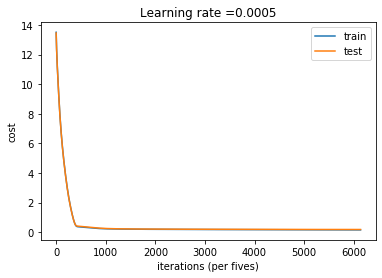

Parameters have been trained!
Train score: 0.15425812206225104
Test score: 0.183021221040079


In [177]:
%time 

# Choose hyper parameters
learning_rate = 0.0005
decay_step = 250
base_rate = 0.91

num_epochs = None 
epsilon = 0.000000001
early_stopping = 100
n_units = [90,50,70,30,40,20,10]
activation = 'relu' 
loss_fn = 'RMSE log'
optimizer = 'Adam'
# batch_size to implement

# Helper parameters
display_freq = 500

parameters = neural_network(X_train, y_train, X_test, y_test,
                           learning_rate, decay_step, base_rate,
                            num_epochs, epsilon, early_stopping,
                           n_units, activation, loss_fn, optimizer,
                           display_freq)

# see model validation
model_validation(X_train, y_train, X_test, y_test, parameters)

## Run on test and save submission

In [178]:
def pred_and_format_for_kaggle(test, parameters, save=True):
    ids = test['Id']
    X = test.drop(columns='Id')
    
    preds = pd.DataFrame(predict(X, parameters))
    
    output = pd.concat([ids, preds], axis=1)
    output.columns = ['Id','SalePrice']
    
    if save:
        output.to_csv('data/submission.csv', index=False)
    
    return output

In [179]:
test_columns = [c for c in cols_to_keep if c != target]
test_df, _ , _ = prepare_data(test, test_columns, target, 
                              dummies_cols, transformer)
test_df['Id'] = test['Id']

In [180]:
output = pred_and_format_for_kaggle(test_df, parameters, save=True)
(output['SalePrice'] < 1000).sum()

0

In [181]:
output.sample(10)

,Id,SalePrice
1087,2548,124962.890625
1345,2806,115071.953125
336,1797,112603.890625
283,1744,375710.843750
690,2151,140233.578125
1294,2755,132624.390625
889,2350,332385.156250
438,1899,186297.515625
1042,2503,79788.304688
716,2177,226972.078125


## The end.